# PART 2 - MLP

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all names
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# build vocab
chars = sorted(
    list( set(''.join(words) ) )
)
stoi = {s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [141]:
# build dataset

def build_dataset(words):
    
    block_size = 3 # context length, how many chars to take to predict next 1
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [142]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [152]:
# 5 words -> 32 samples
X.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [150]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

### embedding
lets project our vocabulary (27 chars) into lower dimension space.  lets start with 2 for 2d


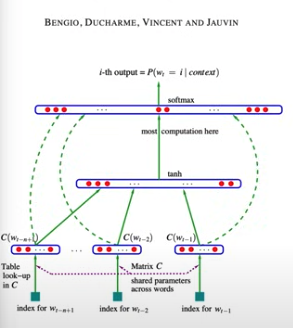

In [9]:
C = torch.randn((27, 2))

In [11]:
# we can index embedding C, using a multi dim tensor, in our case X=[32, 3]
C[X].shape

torch.Size([32, 3, 2])

In [21]:
C[X][7, 2]

tensor([ 0.7820, -3.0774])

In [22]:
C[12]

tensor([ 0.7820, -3.0774])

In [23]:
# so embedding is basically C[X]
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [24]:
# non-linear layer inputs: [block_size * emb_dim] = 3x2 = 6
# number of neurals, lets say 100
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [151]:
# emb is size [32,3,2], doesnt match W1
# we need to manipulate emb to get shape of [32, 6]

# tensor.view() lets you change shape
emb.view(32, 6)

RuntimeError: shape '[32, 6]' is invalid for input of size 135930

In [33]:
# now we can do matrix mult for hidden states
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.9969, -0.5079,  0.7834,  ...,  0.4108, -0.7926,  0.2331],
        [ 0.9801,  0.1690, -0.4326,  ...,  0.4789, -0.9741,  0.1492],
        [ 1.0000, -0.8853,  0.9851,  ..., -0.8810,  0.7192,  0.9999],
        ...,
        [ 0.5677,  0.9708,  0.2511,  ...,  0.9868, -0.9940, -0.9527],
        [ 0.9992,  0.9484, -0.8915,  ...,  0.9170, -0.9972, -0.7400],
        [ 0.9962,  0.9918,  0.2795,  ...,  0.9975, -0.9944, -0.6472]])

In [34]:
h.shape

torch.Size([32, 100])

In [35]:
# final layer that can perform softmax
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [36]:
logits = h @ W2 + b2

In [37]:
logits.shape

torch.Size([32, 27])

In [38]:
counts = logits.exp()

In [39]:
prob = counts / counts.sum(1, keepdims=True)

In [40]:
prob[0].sum()

tensor(1.0000)

In [42]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.2078)

In [43]:
# now make things respectable

In [153]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [201]:
g = torch.Generator().manual_seed(2147483647) # reproducibility
# embedding, 2d for each vocab, 27 total
C = torch.randn((27, 10), generator=g)
# layer 1, [context, hidden_size]=[3 word embedding, 100]=[6, 100]
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
# layer 2, [100, 27], output softmax
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [173]:
sum(p.nelement() for p in parameters) # total number of params in network

11897

In [71]:
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
# this is common classification/cross_entropy loss
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[ torch.arange(32), Y ].log().mean()
loss

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [52]:
# more efficient
# - no new mem for intermediate steps
# - numerical operation more stable
# - faster operation because of fused operation kernels
F.cross_entropy(logits, Y)

tensor(17.7697)

In [182]:
# learning rate, from 0.001, 100, increment exponentially
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [214]:
lri = []
lossi = []
stepi = []

for i in range(10000):
    # mini batch indices
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr][ix] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])

    if i % 50 == 0:
        print(f'{i}: {loss.item()}')
    
    # backward pass
    for p in parameters:
        # reset gradient
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.003162 # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())

0: 2.164694309234619
50: 2.0811684131622314
100: 2.0225956439971924
150: 2.145901679992676
200: 2.1613564491271973
250: 2.111445903778076
300: 2.2098543643951416
350: 2.2980871200561523
400: 2.1951773166656494
450: 2.1392312049865723
500: 2.237290620803833
550: 2.120211601257324
600: 2.223379373550415
650: 2.1967010498046875
700: 2.3022048473358154
750: 2.2850749492645264
800: 2.1485822200775146
850: 2.3820972442626953
900: 2.0919981002807617
950: 2.309422731399536
1000: 2.0537147521972656
1050: 2.460697889328003
1100: 2.149998188018799
1150: 2.2294867038726807
1200: 2.5795986652374268
1250: 2.0569212436676025
1300: 2.224970579147339
1350: 2.188175916671753
1400: 2.1359002590179443
1450: 2.3834171295166016
1500: 2.5639936923980713
1550: 2.265131950378418
1600: 2.413527011871338
1650: 2.3937034606933594
1700: 2.2388205528259277
1750: 2.0608468055725098
1800: 2.236905813217163
1850: 2.1927216053009033
1900: 2.3211708068847656
1950: 2.320042610168457
2000: 2.33000111579895
2050: 2.5012195

In [193]:
10**-0.5

0.31622776601683794

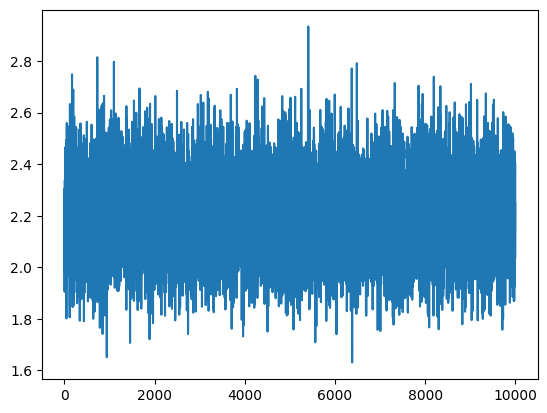

In [215]:
plt.plot(stepi, lossi) # learning rate

In [216]:
# loss for the dev set
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2136, grad_fn=<NllLossBackward0>)

In [217]:
# loss for the train set and not batch
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1931, grad_fn=<NllLossBackward0>)

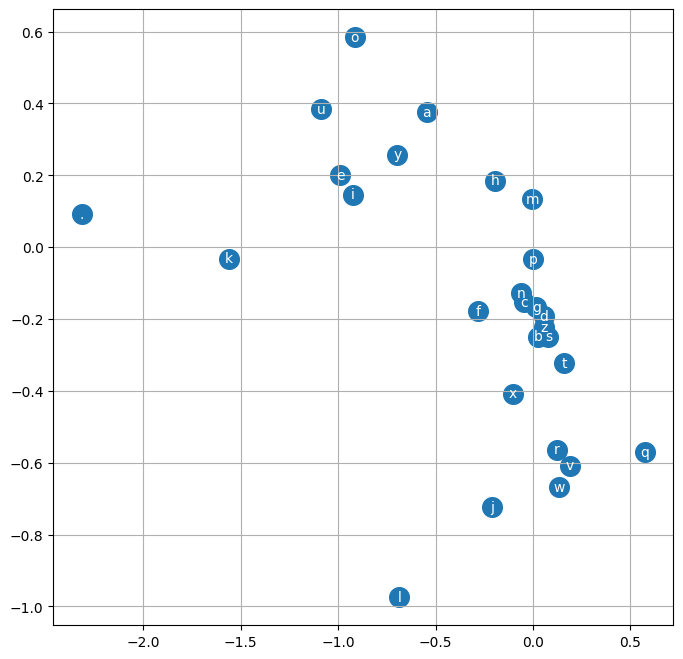

In [218]:
# plot embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:,3].data, C[:,4].data, s=200)

for i in range(C.shape[0]):
    plt.text( C[i,3].item(), C[i,4].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [221]:
# sample from current model
g = torch.Generator().manual_seed(2147483647 + 10) # reproducibility

# generate 20 names
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # start with '...'
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carpah.
amelle.
khi.
mili.
thay.
sacassaeja.
hubadden.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jori.
quinn.
shorlei.
jadii.
wazelogiearynix.
kaequinsley.
daedo.
